# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import zipfile 
import re
import geopandas as gpd
import pylab as pl
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#!for ((y=94; y<=99; y+=1)); do wget \
#https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

#!for ((y=0; y<=1; y+=1)); do wget \
#https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

#!for ((y=2; y<=9; y+=1)); do wget \
#https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=10; y<=14; y+=1)); do wget \
#https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

In [3]:
!wget 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'

--2017-12-13 22:31:10--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.68.26
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2017-12-13 22:31:10--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “application%2Fzip”

100%[======================================>] 1,514,401   1.97M/s   in 0.7s    

2017-12-13 22:31:11 (1.97 MB/s) - “application%2Fzip” saved [1514401/1514401]



In [4]:
os.system("unzip application%2Fzip -d " + os.getenv("PUIDATA") + '/zip_code_shape')
!rm application%2Fzip

In [5]:
names1 = range(0, 15)
names2 = range(94, 100)
names = np.array(names1 + names2)

In [6]:
zf = zipfile.ZipFile('zbp00totals.zip')
df = pd.read_csv(zf.open('zbp00totals.zip'.replace('.zip', '.txt')))
df = df.rename(columns = str.lower)
df['year']=str(2000)
for i in range(1, len(names)):
    if i<10:
        fname = 'zbp0' + str(names[i]) + 'totals.zip'
        zf = zipfile.ZipFile(fname)
    if i>=10:
        fname = 'zbp' + str(names[i]) + 'totals.zip'
        zf = zipfile.ZipFile(fname)
    df1 = pd.DataFrame(pd.read_csv(zf.open(fname.replace('.zip', '.txt'))))
    df1 = df1.rename(columns=str.lower)
    if i>=15:
        df1['year']=str(1900+names[i])
    if i<15:
        df1['year']=str(2000+names[i])
    df = pd.concat([df,df1])

In [7]:
df = df.drop(['ap', 'ap_nf', 'city', 'cty_name', 'emp', 'emp_nf', 'empflag', 'name', 'qp1', 'qp1_nf', 'stabbr'], axis=1)

In [8]:
data = pd.pivot_table(df, values='est', index=['zip'], columns = ['year'])
data = data.dropna(axis = 0)

In [9]:
nyc_zip = gpd.GeoDataFrame.from_file(os.path.join(os.getenv('PUIDATA')
                                                  + "/zip_code_shape", 
                                                  'ZIP_CODE_040114.shp'))

In [10]:
nyc_zip.ZIPCODE = nyc_zip.ZIPCODE.astype(int)
data['zip'] = data.index.astype(int)

In [11]:
data = nyc_zip[['ZIPCODE','geometry']].merge(data, left_on = 'ZIPCODE', right_on = 'zip', how = 'left')

In [12]:
data = data.dropna(axis = 0)
data = data.drop(['ZIPCODE'], axis = 1)
data.index = data.zip

In [13]:
data = data.drop(['zip'], axis = 1)

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



In [14]:
for i in range(0, len(data)):
    sigma = data.iloc[i, -21:].std()
    mu = data.iloc[i, -21:].mean()
    for j in range(1,22):
        data.iloc[i, j] = (data.iloc[i, j]-mu) / sigma
        #print (i,j)

## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [15]:
KM = KMeans(n_clusters = 6, random_state = 123).fit(data.iloc[:,1:22])

In [16]:
data['KM6'] = KM.labels_

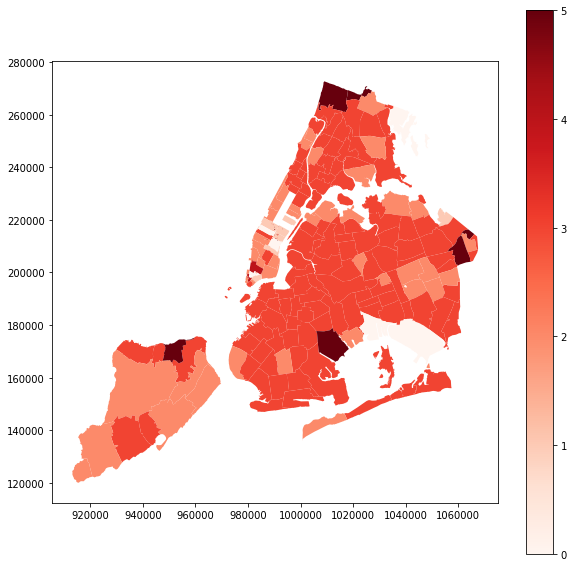

In [17]:
data.plot(column = 'KM6', cmap="Reds", figsize = (10,10), legend = True);

### Figure 1
Cloropleth of cluster centers for 6 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster

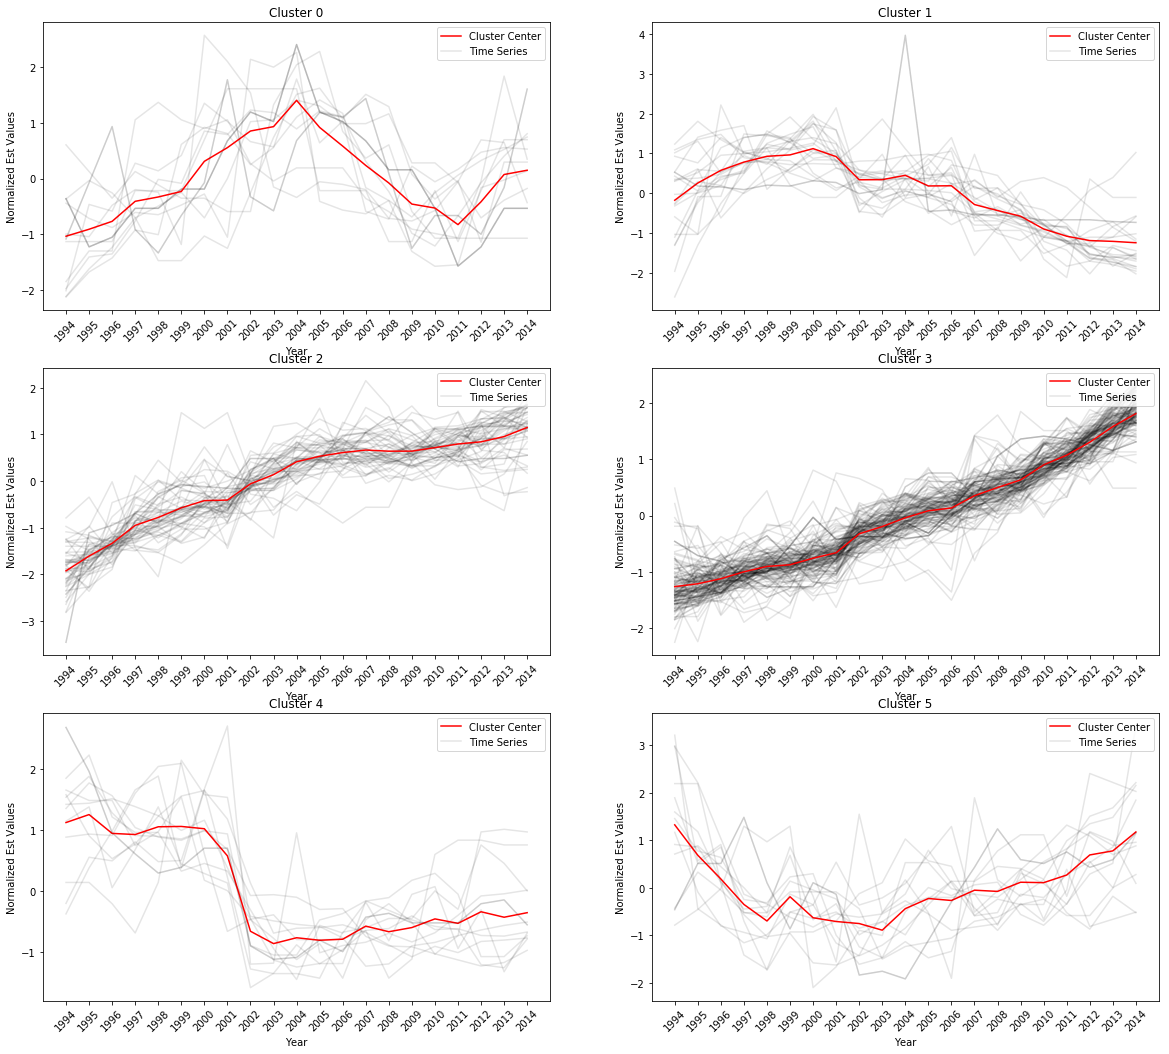

In [62]:
fig = pl.figure(figsize = (20 ,18))
ax0,ax1,ax2 = fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323)
ax3,ax4,ax5 = fig.add_subplot(324), fig.add_subplot(325), fig.add_subplot(326)
cluster = [0, 1, 2, 3, 4, 5]
index = [ax0, ax1, ax2, ax3, ax4, ax5]
for k in range(0,6):
    for i in range(0,len(data[(data.KM6==k)])-1):
        index[k].plot(data.columns[1:22],data[(data.KM6==k)].iloc[i,1:22], color='k', alpha=0.1)
    clusterc,=index[k].plot(data.columns[1:22], KM.cluster_centers_[cluster[k]], color='r',label='Cluster Center')
    timeseries,=index[k].plot(data.columns[1:22],data[(data.KM6==k)].iloc[i,1:22], color='k', alpha=0.1,label='Time Series')
    index[k].set_xticks(range(1994, 2015));
    index[k].set_xticklabels(range(1994, 2015), rotation=45)
    index[k].set_ylabel('Normalized Est Values')
    index[k].set_xlabel('Year')
    index[k].legend(handles=[clusterc,timeseries],loc=1)
    index[k].set_title('Cluster '+str(k))
    index[k];

### Figure 2 
Business pattern time series for each cluster with their centers

In [19]:
GM = GaussianMixture(n_components=6, random_state = 123)
GM.fit(data.iloc[:,1:22])
res_Mix=GM.predict(data.iloc[:,1:22])
data['GM6'] = res_Mix

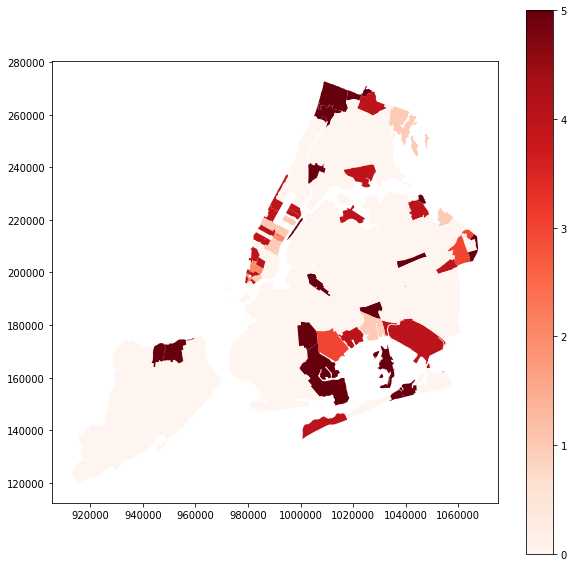

In [61]:
data.plot(column = 'GM6', cmap="Reds", figsize = (10,10), legend = True);

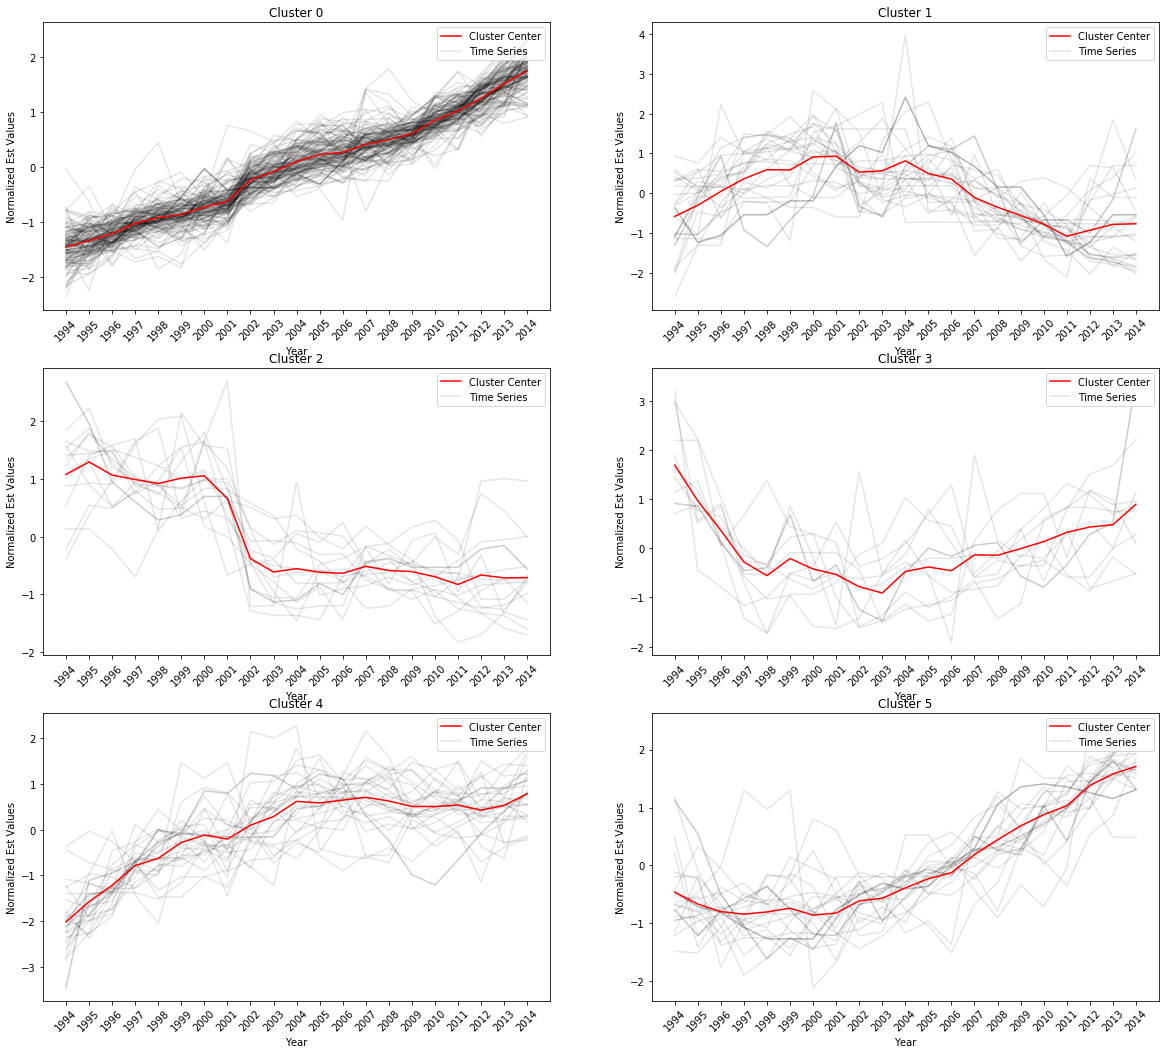

In [60]:
fig = pl.figure(figsize = (20 ,18))
ax0,ax1,ax2 = fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323)
ax3,ax4,ax5 = fig.add_subplot(324), fig.add_subplot(325), fig.add_subplot(326)
cluster = [0, 1, 2, 3, 4, 5]
index = [ax0, ax1, ax2, ax3, ax4, ax5]
for k in range(0,6):
    for i in range(0,len(data[(data.GM6==k)])-1):
        index[k].plot(data.columns[1:22],data[(data.GM6==k)].iloc[i,1:22], color='k', alpha=0.1)
    clusterc,=index[k].plot(data.columns[1:22], list(data[(data.GM6==k)].iloc[:,1:22].mean(axis = 0)), color='r',label='Cluster Center')
    timeseries,=index[k].plot(data.columns[1:22],data[(data.GM6==k)].iloc[i,1:22], color='k', alpha=0.1,label='Time Series')
    index[k].set_xticks(range(1994, 2015));
    index[k].set_xticklabels(range(1994, 2015), rotation=45)
    index[k].set_ylabel('Normalized Est Values')
    index[k].set_xlabel('Year')
    index[k].legend(handles=[clusterc,timeseries],loc=1)
    index[k].set_title('Cluster '+str(k))
    index[k];

### Let's compare both algorithms

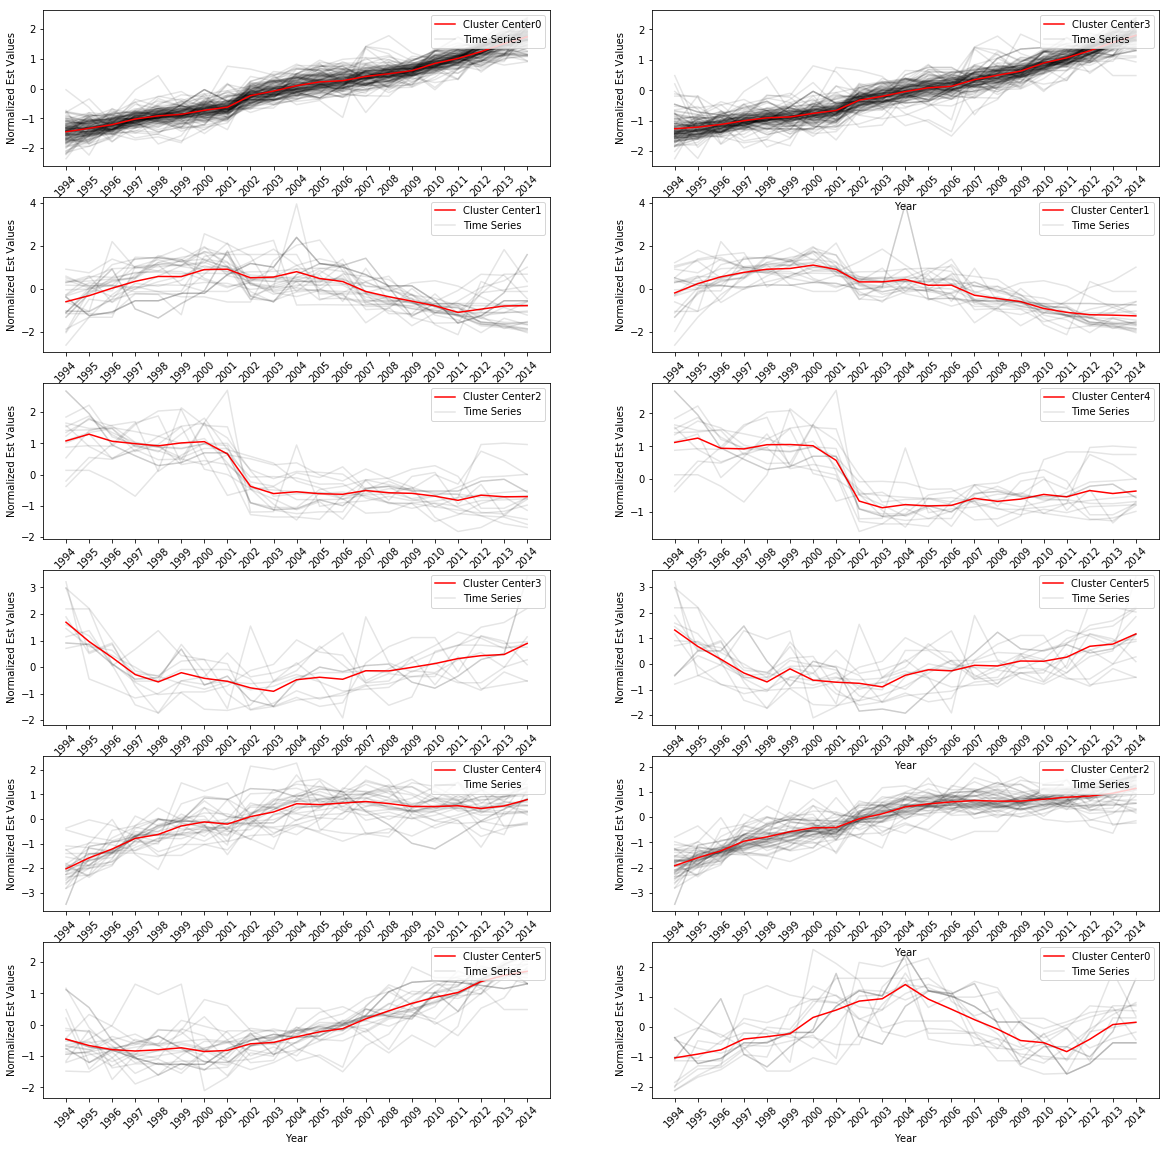

In [48]:
fig = pl.figure(figsize = (20 ,20))
ax0,ax2,ax4 = fig.add_subplot(621), fig.add_subplot(623), fig.add_subplot(625)
ax6,ax8,ax10 = fig.add_subplot(627), fig.add_subplot(629), fig.add_subplot(6, 2, 11)
ax1,ax3,ax5 = fig.add_subplot(6, 2, 12), fig.add_subplot(624), fig.add_subplot(6, 2, 10)
ax7,ax9,ax11 = fig.add_subplot(622), fig.add_subplot(626), fig.add_subplot(628)
cluster = [0, 1, 2, 3, 4, 5]
index = [ax0, ax2, ax4, ax6, ax8, ax10, ax1, ax3, ax5, ax7, ax9, ax11]
for k in range(0,6):
    for i in range(0,len(data[(data.GM6==k)])-1):
        index[k].plot(data.columns[1:22],data[(data.GM6==k)].iloc[i,1:22], color='k', alpha=0.1)
    clusterc,=index[k].plot(data.columns[1:22], list(data[(data.GM6==k)].iloc[:,1:22].mean(axis = 0)), color='r',label='Cluster Center '+str(k))
    timeseries,=index[k].plot(data.columns[1:22],data[(data.GM6==k)].iloc[i,1:22], color='k', alpha=0.1,label='Time Series')
    index[k].set_xticks(range(1994, 2015));
    index[k].set_xticklabels(range(1994, 2015), rotation=45)
    index[k].set_ylabel('Normalized Est Values')
    index[k].set_xlabel('Year')
    index[k].legend(handles=[clusterc,timeseries],loc=1)
    #index[k].set_title('Cluster '+str(k))
    index[k];
for k in range(0,6):
    for i in range(0,len(data[(data.KM6==k)])-1):
        index[k+6].plot(data.columns[1:22],data[(data.KM6==k)].iloc[i,1:22], color='k', alpha=0.1)
    clusterc,=index[k+6].plot(data.columns[1:22], KM.cluster_centers_[cluster[k]], color='r',label='Cluster Center '+str(k))
    timeseries,=index[k+6].plot(data.columns[1:22],data[(data.KM6==k)].iloc[i,1:22], color='k', alpha=0.1,label='Time Series')
    index[k+6].set_xticks(range(1994, 2015));
    index[k+6].set_xticklabels(range(1994, 2015), rotation=45)
    index[k+6].set_ylabel('Normalized Est Values')
    index[k+6].set_xlabel('Year')
    index[k+6].legend(handles=[clusterc,timeseries],loc=1)
    #index[k+6].set_title('Cluster '+str(k))
    index[k+6];

#### Cluster 0 and 3 is most of Brooklyn, Queens, Harlem and The Bronx
They both show an increasing trend in business development and probably the area in New York City that have been gentrified the most over that twenty year span
#### Cluster 1 and 1 is midtown
This shows an increasing trend that peaks circa 2002 only to start slowy descending
#### Cluster 2 and 4 are close to Greenwich Village in Manhattan
This shows a strong fall in commerce est after 2001 that never recovers
#### Cluster 3 and 5 are East New York in Bk
Decreasing trend until 2001 increasing afterwards
#### Cluster 4 and 2 Howard Beach in Bk, Upper East Side in Manhattan, Sound View & Union Port in The Bronx
Overall increasing trend
#### Cluster 5 and 0 are the most different so I cant really tell